In [60]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device, batch_data_by_country

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
import utils.results as results
import torch
import torch.nn as nn

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [61]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction
device = get_device()

In [62]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [63]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

x_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
x_valid_t = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device)
x_hf_t = torch.tensor(x_hf, dtype=torch.float32).to(device)

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Smoothing Model

In [64]:
preprocessor.dates_high_freq
preprocessor.country_high_freq

df_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [x_hf[i] for i in range(len(x_hf))]
})

df_x_train = pd.DataFrame({
    'date': preprocessor.dates_train.copy(),
    'country': preprocessor.country_train.copy(),
    'data': [X_train[i].copy() for i in range(len(X_train))],
    'y_true': [y_train[i].copy() for i in range(len(y_train))]
})

df_hf['date'] = pd.to_datetime(df_hf['date'])
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

In [65]:
from torch.nn import MSELoss

def smoothness_loss(y_pred, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    if y_pred.shape[1] > 1:
        # Compute the loss related to smoothness
        smoothness_loss_ord1 = 0
        for i in range(1, 4):
            # Divide by 3 because dt is 1/3 month, and by 4 because we have 4 time points and we average them
            smoothness_loss_ord1 += torch.linalg.norm((y_pred[:, i, :] - y_pred[:, i - 1, :])) ** 2 / (3 * 4 * y_pred.shape[0])

        # Constraint on the double derivative
        smoothness_loss_ord2 = 0
        for i in range(2, 4):
            smoothness_loss_ord2 += torch.linalg.norm(y_pred[:, i, :] - 2 * y_pred[:, i - 1, :] + y_pred[:, i - 2, :]) ** 2 / (3 * 4 * y_pred.shape[0])

        return smoothness_loss_ord1 * smoothness_weight_ord1 + smoothness_loss_ord2 * smoothness_weight_ord2

    else:
        raise ValueError("Input shape not supported!")

def custom_loss(y_pred, y_true, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    # Compute usual MSE on actual GDP values
    mse = MSELoss()

    if y_pred.shape[1] > 1:
        prediction_loss = mse(y_pred[:, -1, :], y_true)  # First column is the actual GDP

        smooth_loss = smoothness_loss(y_pred, smoothness_weight_ord1, smoothness_weight_ord2)

        return prediction_loss + smooth_loss
    elif y_pred.shape[1] == 1:
        return mse(y_pred, y_true)
    else:
        raise ValueError("Input shape not supported!")

In [66]:
augmented_data, filtered_countries, filtered_dates, y_augmented_train, _ = batch_data_by_country(df_x_train, 
                                                                                              df_hf, 
                                                                                              3, 
                                                                                              0, 
                                                                                              ['y_true'], 
                                                                                              False)

y_augmented_train = np.array(y_augmented_train).squeeze().astype(np.float32)

Using cpu device


100%|██████████| 100/100 [00:05<00:00, 19.05it/s]


Final training loss: 0.3424474000930786
Final validation loss: 0.435703843832016
Final validation R^2: 0.4208178526380604


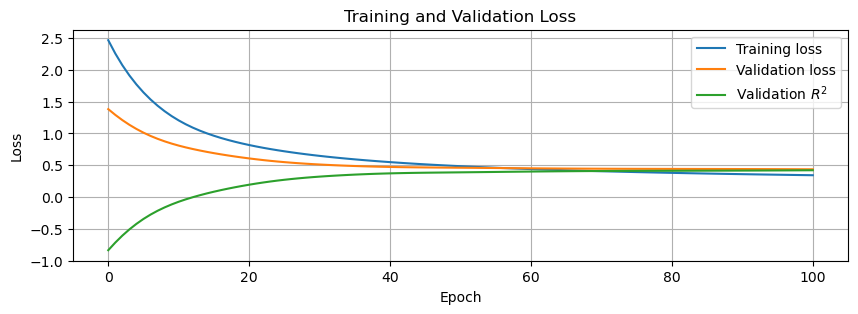

[0.01158107657638932, 0.09066878624682156]

In [67]:
smoothness_weight_ord1=5
smoothness_weight_ord2=10
model, training_loss, validation_loss, validation_r_squared, global_mse_losses = train_nn(augmented_data, 
                                                                        y_augmented_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=1e-4, 
                                                                        weight_decay=1e-2, 
                                                                        verbose=True,
                                                                        current_gdp_idx=-1,
                                                                        custom_loss=lambda x, y: custom_loss(x, y, smoothness_weight_ord1, smoothness_weight_ord2),
                                                                        seed=SEED)
global_mse_losses[-1]

In [68]:
device = get_device(False)

# Get the predictions
y_pred = model(x_valid_t).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train_t).clone().detach().cpu().numpy().squeeze()
y_pred_hf = model(x_hf_t).clone().detach().cpu().numpy().squeeze()

In [69]:

# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])
predictions_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'y_pred': y_pred_hf,
    'Set': 'High Frequency'
})


# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

predictions_hf_melted = predictions_hf.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    filtered_data_hf = predictions_hf_melted[predictions_hf_melted["country"] == selected_country]

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data_hf,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True, palette="Set3"
    )
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

## Other smoothness Loss

In [70]:
# Batch by country
other_augmented_data, other_filtered_countries, other_filtered_dates, other_y_augmented_train, _ = batch_data_by_country(df_x_train, 
                                                                                                    df_hf, 
                                                                                                    5, 
                                                                                                    0, 
                                                                                                    ['y_true'], 
                                                                                                    False)

In [71]:
from torch.nn import MSELoss

def smoothness_loss(y_pred, smoothness_weight_ord1=0.33, smoothness_weight_ord2=0.33):
    if y_pred.shape[1] > 1:
        # Compute the loss related to smoothness
        smoothness_loss_ord1 = 0
        for i in range(1, 4):
            # Divide by 3 because dt is 1/3 month, and by 4 because we have 4 time points and we average them
            smoothness_loss_ord1 += torch.linalg.norm((y_pred[:, i, :] - y_pred[:, i - 1, :])) ** 2 / (3 * 4 * y_pred.shape[0])

        # Constraint on the double derivative
        smoothness_loss_ord2 = 0
        for i in range(2, 4):
            smoothness_loss_ord2 += torch.linalg.norm(y_pred[:, i, :] - 2 * y_pred[:, i - 1, :] + y_pred[:, i - 2, :]) ** 2 / (3 * 4 * y_pred.shape[0])

        return smoothness_loss_ord1 * smoothness_weight_ord1 + smoothness_loss_ord2 * smoothness_weight_ord2

    else:
        raise ValueError("Input shape not supported!")
    
def holder_exponent(series):
    """Estimate the Hölder exponent."""
    diff = torch.abs(torch.diff(series))
    return -torch.log(torch.mean(diff)) / torch.log(torch.tensor(len(series)))

def std_first_derivative(series):
    """Standard deviation of the first derivative (finite differences)."""
    diff = torch.diff(series)
    return torch.std(diff)

def mean_abs_first_difference(series):
    """Mean absolute first difference."""
    diff = torch.diff(series)
    return torch.mean(torch.abs(diff))

def std_second_derivative(series):
    """Variance or standard deviation of the second derivative."""
    second_diff = torch.diff(series, n=2)
    return torch.std(second_diff)

def total_variation(series):
    """Total variation."""
    diff = torch.diff(series)
    return torch.sum(torch.abs(diff)) / series.shape[0]

smooth_functions = [holder_exponent, std_first_derivative, mean_abs_first_difference, std_second_derivative, total_variation]

def custom_loss(y_pred, y_true, weights=[1, 1, 1, 1, 1, 1, 1]):
    # Compute usual MSE on actual GDP values
    mse = MSELoss()

    if y_pred.shape[1] > 1:
        prediction_loss = mse(y_pred[:, -1, :].squeeze(), y_true.squeeze())  # First column is the actual GDP

        smooth_loss = smoothness_loss(y_pred, weights[0], weights[1])

        for i, f in enumerate(smooth_functions):
            smooth_loss += f(y_pred.squeeze()) * weights[i + 2]

        return prediction_loss + smooth_loss
    elif y_pred.shape[1] == 1:
        return mse(y_pred, y_true)
    else:
        raise ValueError("Input shape not supported!")

Using cpu device


100%|██████████| 100/100 [00:05<00:00, 18.57it/s]


Final training loss: 1.2652511596679688
Final validation loss: 0.46282798051834106
Final validation R^2: 0.3847616999000225


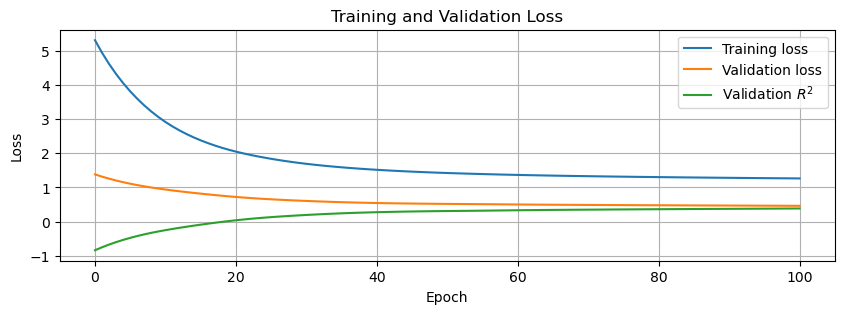

In [72]:
ultra_smooth_model, ultra_smooth_training_loss, ultra_smooth_validation_loss, ultra_smooth_validation_r_squared, ultra_smooth_global_mse_losses = train_nn(augmented_data, 
                                                                        y_augmented_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=1e-4, 
                                                                        weight_decay=1e-2, 
                                                                        verbose=True,
                                                                        current_gdp_idx=-1,
                                                                        custom_loss=lambda x, y: custom_loss(x, y, [smoothness_weight_ord1, smoothness_weight_ord2, 1, 1, 1, 1, 1]),
                                                                        seed=SEED)

In [73]:
ultra_smooth_y_pred_valid = ultra_smooth_model(x_valid_t).clone().detach().cpu().numpy().squeeze()
ultra_smooth_y_pred_train = ultra_smooth_model(x_train_t).clone().detach().cpu().numpy().squeeze()
ultra_smooth_y_pred_hf = ultra_smooth_model(x_hf_t).clone().detach().cpu().numpy().squeeze()

## Mesure smoothness

Using cpu device


100%|██████████| 100/100 [00:02<00:00, 45.98it/s]


Final training loss: 0.016868053004145622
Final validation loss: 0.5011270642280579
Final validation R^2: 0.3338506673529006


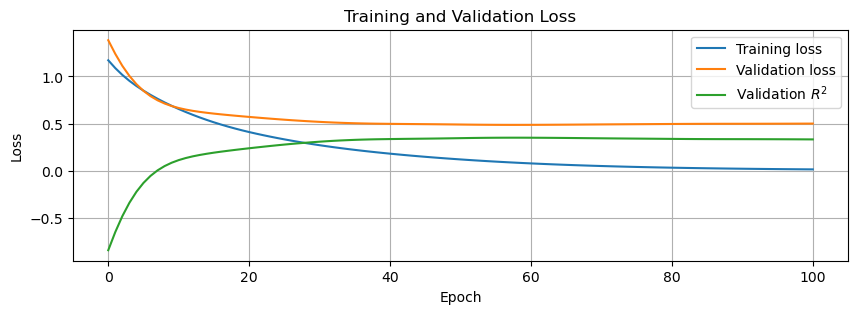

Basic R2 score: 0.3338506673529006
Adjusted R2 score: 0.4208178526380604


In [74]:
basic_model, basic_training_loss, basic_validation_loss, basic_validation_r_squared, basic_global_mse_losses = train_nn(X_train, 
                                                                        y_train, 
                                                                        X_valid, 
                                                                        y_valid, 
                                                                        num_epochs=100, 
                                                                        learning_rate=1e-4, 
                                                                        weight_decay=1e-2, 
                                                                        verbose=True,
                                                                        seed=SEED)

# Get the predictions
basic_y_pred_hf = basic_model(torch.tensor(x_hf, dtype=torch.float32).to(device)).clone().detach().cpu().numpy().squeeze()
basic_r2_score = results.r2_score(y_valid, basic_model(x_valid_t).clone().detach().cpu().numpy().squeeze())

# R2 on hf
adjusted_r2_score = results.r2_score(y_valid, model(x_valid_t).clone().detach().cpu().numpy().squeeze())

print(f"Basic R2 score: {basic_r2_score}")
print(f"Adjusted R2 score: {adjusted_r2_score}")

In [75]:
results.measure_smoothness(basic_y_pred_hf, preprocessor.dates_high_freq, preprocessor.country_high_freq)

[0.937651546699905, 0.636788012043136, 0.01882996546694025]

In [76]:
results.measure_smoothness(y_pred_hf, preprocessor.dates_high_freq, preprocessor.country_high_freq)

[0.2629176096377732, 0.245767648269788, 0.007212419481716609]

In [77]:
results.measure_smoothness(ultra_smooth_y_pred_hf, preprocessor.dates_high_freq, preprocessor.country_high_freq)

[0.15620818907673778, 0.14790466189224866, 0.0033556570529194372]

## Compare on multiple weights

In [78]:
df_hf_squeezed = {
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': x_hf_t.clone().detach().cpu().numpy().squeeze(),
}

In [ ]:
basic_train_fn = lambda seed: train_nn(X_train, 
                                 y_train, 
                                 X_valid, 
                                 y_valid,
                                 num_epochs=100, 
                                 learning_rate=1e-4, 
                                 weight_decay=1e-2, 
                                 verbose=False, 
                                 seed=seed)

smooth_train_fn = lambda seed: train_nn(augmented_data, 
                                 y_augmented_train, 
                                 X_valid, 
                                 y_valid,
                                 num_epochs=100, 
                                 learning_rate=1e-4, 
                                 weight_decay=1e-2, 
                                 verbose=False, 
                                 seed=seed, 
                                 custom_loss=lambda x, y: custom_loss(x, y,  [smoothness_weight_ord1, smoothness_weight_ord2, 0, 0, 0, 0, 0]))

other_losses_importance = 0.5
ultra_smooth_train_fn = lambda seed: train_nn(other_augmented_data,
                                              other_y_augmented_train,
                                              X_valid,
                                              y_valid,
                                              num_epochs=100,
                                              learning_rate=1e-4,
                                              weight_decay=1e-2,
                                              verbose=False,
                                              seed=seed,
                                              custom_loss=lambda x, y: custom_loss(x, y, [smoothness_weight_ord1, smoothness_weight_ord2] + 5 * [other_losses_importance]))


basic_bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, basic_train_fn, n_ensembling=100, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)
smooth_bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, smooth_train_fn, n_ensembling=100, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)
ultra_smooth_bootstrapped_results = results.bootstrap_ensemble(X_valid, y_valid, ultra_smooth_train_fn, n_ensembling=100, seed=SEED, device=get_device(False), other_pred_set=df_hf_squeezed)


Bootstrapping Ensembling:  23%|██▎       | 23/100 [02:32<07:36,  5.93s/it]

In [ ]:
def plot_summary(ensemble, metric_name):
    sns.histplot(ensemble, bins=30, kde=True)
    plt.axvline(x=np.median(ensemble), color='darkorange', linestyle='--', label=f'Median {metric_name}', linewidth=2)

    plt.xlabel(metric_name)
    plt.ylabel("Density")
    plt.title(f"Distribution of {metric_name} values")

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plot_summary(basic_bootstrapped_results['rsquared_ensemble'], "$R^2$ Score")
plt.subplot(1, 3, 2)
plot_summary(smooth_bootstrapped_results['rsquared_ensemble'], "$R^2$ Score")
plt.subplot(1, 3, 3)
plot_summary(ultra_smooth_bootstrapped_results['rsquared_ensemble'], "$R^2$ Score")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plot_summary(basic_bootstrapped_results['other_pred_smoothness'], "Smoothness Error")
plt.subplot(1, 3, 2)
plot_summary(smooth_bootstrapped_results['other_pred_smoothness'], "Smoothness Error")
plt.subplot(1, 3, 3)
plot_summary(ultra_smooth_bootstrapped_results['other_pred_smoothness'], "Smoothness Error")
plt.tight_layout()
plt.show()